# Notebook 1

## Mutliple Linear Regression Modeling (ISLR Chapter 3)

This dataset using US Census data from the 2019 ACS 5 year survey along with COVID-19 vaccination rate data from the Louisiana Department of Health. Data is organized by census tract. The first portion of this Notebook is include the data cleaning and manipulation code. For linear modeling teaching puropses, please start at [Changing Data Type](#start_here).

In [1]:
import os
import pandas as pd

In [2]:
dir_main = os.getcwd()

In [3]:
dir_cleaning = os.path.join(dir_main, 'data', 'cleaning')

In [4]:
lst_names = os.listdir(dir_cleaning)
lst_names

lst_temp = []
for name in lst_names: # Filter system files out
    if not name.startswith('.'):
        lst_temp.append(name)
lst_names = lst_temp

In [5]:
lst_names

['ACSDT5Y2019.B08201_data_with_overlays_2021-06-15T154037.csv',
 'ACSST5Y2019.S2301_data_with_overlays_2021-06-15T114804.csv',
 'ACSDT5Y2019.B02001_data_with_overlays_2021-06-10T164336.csv',
 'ACSST5Y2019.S1501_data_with_overlays_2021-06-15T160409.csv',
 'ACSST5Y2019.S1901_data_with_overlays_2021-06-15T155942.csv']

In [6]:
lst_dfs = []
for name in lst_names:
    df_temp = pd.read_csv(os.path.join(dir_cleaning, name), header=None)
    
    df_temp.drop(df_temp.index[0], inplace=True) # Delete unneeded header
    new_header = df_temp.iloc[0] # Grab the first row for the header
    df_temp = df_temp[1:] # Take the data less the header row
    df_temp.columns = new_header # Set the header row as the df header
    
    lst_dfs.append(df_temp)

/Users/steele/opt/anaconda3/envs/ISLR/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,54

In [7]:
from functools import reduce

In [8]:
df_merged = reduce(lambda x, y: pd.merge(x, y, on='id'), lst_dfs) # Combine all dataframes together

In [9]:
df_stats = df_merged[['id',
                      'Labor Force Participation 16 and Older Percent',
                      'Median Household Income',
                      'Black Percent',
                      'No Vehicle Household Percent', 
                      'Population High School Graduate or Equivalency or Higher Percent']]

In [10]:
df_vac = pd.read_csv(os.path.join(dir_main, 'data', '2021.06.28_Vaccinations by Tract.csv'))

In [11]:
# Create column with percent vaccination series completed out of total population for census tract
df_vac['SeriesCompPercent'] = df_vac['SeriesComp']/df_vac['Total_2018Pop'] 

In [12]:
# Add full tract code to vaccination tracts
tracts = df_vac['TractID']
geoid = []
for tract in tracts:
    geoid.append('1400000US' + str(tract))
df_vac['id']  = geoid    

In [13]:
df_vac_orig = df_vac.copy(deep=True)

# Limit to only Orleans Parish
df_vac = df_vac[df_vac.parish == 'Orleans']

In [14]:
df_vac = df_vac[['id', 'Lat', 'Long', 'SeriesInt', 'SeriesComp', 'SeriesCompPercent']]

In [15]:
df = df_vac.merge(df_stats, on='id', copy=False)

<a id='start_here'></a>
### Changing Data Type
As shown below, we've got a mixture of datatypes. We'll need to change these to float in order to start creating linear models. 

In [16]:
df.dtypes

id                                                                   object
Lat                                                                 float64
Long                                                                float64
SeriesInt                                                           float64
SeriesComp                                                          float64
SeriesCompPercent                                                   float64
Labor Force Participation 16 and Older Percent                       object
Median Household Income                                              object
Black Percent                                                        object
No Vehicle Household Percent                                         object
Population High School Graduate or Equivalency or Higher Percent     object
dtype: object

In [17]:
# The linear modeling will require int or float instead of objects,
# so we will convert the columns to numeric.
column_temp = df['id']
df.drop(columns='id', inplace=True)
df = df.apply(pd.to_numeric, errors='coerce') # Convert all columns to numeric
df['id'] = column_temp

df.dtypes

Lat                                                                 float64
Long                                                                float64
SeriesInt                                                           float64
SeriesComp                                                          float64
SeriesCompPercent                                                   float64
Labor Force Participation 16 and Older Percent                      float64
Median Household Income                                             float64
Black Percent                                                       float64
No Vehicle Household Percent                                        float64
Population High School Graduate or Equivalency or Higher Percent    float64
id                                                                   object
dtype: object

### Statsmodels

Now let's start creating some models.

In [18]:
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

The first part of the model is the <b>outcome variable</b>, in this case, <code>SeriesCompPercent</code> or the percentage of people in a census tract that have completed the COVID-19 vaccination series. 

In [19]:
model_0 = '''SeriesCompPercent ~ 
            Q("No Vehicle Household Percent")'''
est_0 = smf.ols(model_0 , df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      SeriesCompPercent   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     23.43
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           2.96e-06
Time:                        12:30:49   Log-Likelihood:                 95.966
No. Observations:                 167   AIC:                            -187.9
Df Residuals:                     165   BIC:                            -181.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.5306      0.018     29.036      0.000       0.494       0.567
Q("No Vehicle Household Percent")    -0.0037      0.001     -4.840      0.000      -0.005      -0.002
==============================================================================
Omnibus:                       47.143   Durbin-Watson:                   0.912
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              177.189
Skew:                           1.014   Prob(JB):                     3.34e-39
Kurtosis:                       7.621   Cond. No.                         41.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### What all this output means

<p><b>Adj. R-squared</b> is the overall fit of the model. So we can see that 11.9% of the variability in the data can be accounted for by simply looking at one predictor <code>No Vehicle Household Percent</code> (the percentage of households which do not have access to a vehicle).</p>

<p>The next important output from the data is the <b>P>|t|</b> (AKA the <b>p-value</b>). We really want a low p-value, preferribly below 0.05. When the p-value is below 0.05, we can say that only 5% of the time the value predicted will be accurate will occur by chance. That is to say that 95% of the time it will not be by chance.</p>
<p style='margin-left:10%; margin-right:10%; border-style: dotted'>So for our p-value for <code>No Vehicle Access Percent</code>, out p-value is 0.000. This is not entirely true though. The p-value in this instance is just very very small, so it's being reported as zero. Another way of reporting the p-value is &lt; 0.001, which is more accurate.</p>
<p>The other important point to note is the <b>coef</b>. <code>No Vehicle Household Percent</code> has a negative sign in front of 0.0037. This indicates that as the number of people that have completed the vaccine series increases, the number of households that have access to a vehicle decreases. So, another way of saying this is that the number of households that have access to vehicles is inversely correlated to the number people who have completed the vaccine series.</p>
<p>Does this all make sense? Sure it does~! One hypothesis is that the people who can't get rides to vaccination centers are not getting vaccinated.</p>

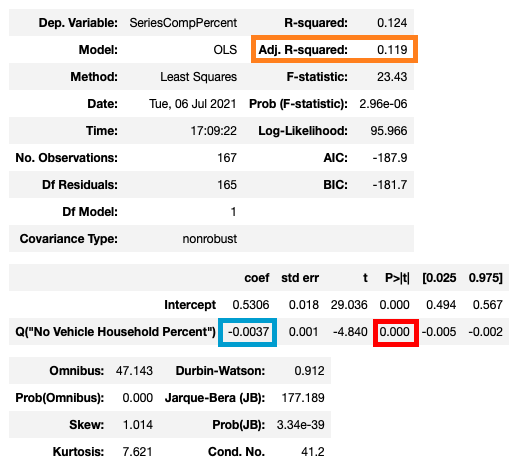

### Adding a Second Predictor
<p>Adding the predictor of <code>Median Household Income</code> increases the <b>Adj. R-squared</b> value to 0.368. Stating this another way, 36.8% of variability can be accounted for by using these two predictors.</p>
<p><u>BUT</u>, we need to know if the predictor is statistically significant. Looking at the <b>p-value</b> for <code>Median Household Income</code> we see that it is 0.000, or less than 0.001 to be more accurate. HOWEVER, notice the <b>p-value</b> for <code>No Vehicle Household Percent</code>. It is now 0.128, so it's not longer statistically significant. As we add more predictors, we can see that some previous predictors may become non-significant as the model grows. (Also note how the <b>coef</b> for <code>No Vehicle Household Percent</code> is no longer negative. This can change as the model grows as well.)</p> 

In [20]:
model_1 = '''SeriesCompPercent ~ 
            Q("No Vehicle Household Percent") + 
            Q("Median Household Income")'''
est_1 = smf.ols(model_1 , df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      SeriesCompPercent   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     49.08
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           2.07e-17
Time:                        12:30:49   Log-Likelihood:                 123.00
No. Observations:                 166   AIC:                            -240.0
Df Residuals:                     163   BIC:                            -230.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.2723      0.036      7.651      0.000       0.202       0.343
Q("No Vehicle Household Percent")     0.0014      0.001      1.531      0.128      -0.000       0.003
Q("Median Household Income")       3.209e-06   3.97e-07      8.079      0.000    2.42e-06    3.99e-06
==============================================================================
Omnibus:                       46.405   Durbin-Watson:                   1.157
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.398
Skew:                           1.046   Prob(JB):                     1.80e-34
Kurtosis:                       7.253   Cond. No.                     2.32e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### <font color='red'>Test For Understanding</font>
Take a look below at the same predictors. We are adding yet another predictor and taking a look at which ones are statistically significant for the model. Which ones are significant? Check your answer below the summary results.

In [21]:
model_2 = '''SeriesCompPercent ~ 
            Q("No Vehicle Household Percent") + 
            Q("Median Household Income") +
            Q("Labor Force Participation 16 and Older Percent")'''
est_2 = smf.ols(model_2 , df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      SeriesCompPercent   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     46.55
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           9.46e-22
Time:                        12:30:49   Log-Likelihood:                 135.47
No. Observations:                 166   AIC:                            -262.9
Df Residuals:                     162   BIC:                            -250.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              -0.0477      0.071     -0.675      0.501      -0.187       0.092
Q("No Vehicle Household Percent")                       0.0027      0.001      3.052      0.003       0.001       0.004
Q("Median Household Income")                         2.884e-06   3.75e-07      7.691      0.000    2.14e-06    3.62e-06
Q("Labor Force Participation 16 and Older Percent")     0.0050      0.001      5.126      0.000       0.003       0.007
==============================================================================
Omnibus:                       46.007   Durbin-Watson:                   1.408
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              181.640
Skew:                           0.972   Prob(JB):                     3.61e-40
Kurtosis:                       7.741   Cond. No.                     4.95e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.95e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### <font color='red'>Test for Understanding: Answer</font>
They They are all significant because their <b>p-values</b> are all less than 0.05. It is important again to note that by adding or dropping predictors.

### Completing the Model
The next two code blocks will add more predictors to see what's significant. Pay close attention to the <b>coef</b> positive and negative sign and the <b>p-values</b> to determine if a predictor is statistically significant. Also note how the <b>Adj. R-squared</b> value is increasing as more predictors are added.

In [22]:
model_3 = '''SeriesCompPercent ~ 
            Q("No Vehicle Household Percent") + 
            Q("Median Household Income") +
            Q("Labor Force Participation 16 and Older Percent") + 
            Q("Population High School Graduate or Equivalency or Higher Percent")'''
est_3 = smf.ols(model_3 , df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      SeriesCompPercent   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     36.84
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           7.50e-22
Time:                        12:30:49   Log-Likelihood:                 137.82
No. Observations:                 166   AIC:                            -265.6
Df Residuals:                     161   BIC:                            -250.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                -0.2691      0.125     -2.160      0.032      -0.515      -0.023
Q("No Vehicle Household Percent")                                         0.0035      0.001      3.686      0.000       0.002       0.005
Q("Median Household Income")                                           2.559e-06   4.01e-07      6.389      0.000    1.77e-06    3.35e-06
Q("Labor Force Participation 16 and Older Percent")                       0.0043      0.001      4.336      0.000       0.002       0.006
Q("Population High School Graduate or Equivalency or Higher Percent")     0.0030      0.001      2.147      0.033       0.000       0.006
==============================================================================
Omnibus:                       42.348   Durbin-Watson:                   1.477
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.240
Skew:                           0.874   Prob(JB):                     1.08e-37
Kurtosis:                       7.643   Cond. No.                     8.82e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.82e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
model_4 = '''SeriesCompPercent ~ 
            Q("No Vehicle Household Percent") + 
            Q("Median Household Income") +
            Q("Labor Force Participation 16 and Older Percent") + 
            Q("Population High School Graduate or Equivalency or Higher Percent") +
            Q("Black Percent")'''
est_4 = smf.ols(model_4, df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      SeriesCompPercent   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     45.00
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           7.76e-29
Time:                        12:30:49   Log-Likelihood:                 156.75
No. Observations:                 166   AIC:                            -301.5
Df Residuals:                     160   BIC:                            -282.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================================================================
                                                                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                 0.3650      0.149      2.448      0.015       0.071       0.659
Q("No Vehicle Household Percent")                                         0.0021      0.001      2.321      0.022       0.000       0.004
Q("Median Household Income")                                            1.01e-06   4.32e-07      2.335      0.021    1.56e-07    1.86e-06
Q("Labor Force Participation 16 and Older Percent")                       0.0020      0.001      2.129      0.035       0.000       0.004
Q("Population High School Graduate or Equivalency or Higher Percent")     0.0002      0.001      0.182      0.856      -0.002       0.003
Q("Black Percent")                                                       -0.0026      0.000     -6.403      0.000      -0.003      -0.002
==============================================================================
Omnibus:                       78.872   Durbin-Watson:                   1.528
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              536.190
Skew:                           1.583   Prob(JB):                    3.70e-117
Kurtosis:                      11.216   Cond. No.                     1.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Reviewing our full model
<p>Several predictors were added, and all predictors would appear to be statistically significant and 57.1% of the variablity was accounted for as shown by the <b>Adj. R-squared</b> value. However, we've got to determine which model is the best. For this we can run an <u>analysis of variance (ANOVA)</u> to determine if there were statistical differences in the models themselves.</p>

<p>The ANOA test works by comparing each liner model to the one before it to determine if there was a significant difference between the them. So, <code>est_1</code> will be compared to <code>est_0</code> and <code>est_2</code> will be compared to <code>est_1</code>, and so on down the line. We can determine if the two models were significantly different by looking at the <b>Pr(>F) (the p-value)</b>. In this case each model is significantly different from its previous model as all the p-values are less than 0.05. If the <b>p-value</b> was not less than 0.05, and thus the model was not significantly different, we could say that adding the predictor was not making the model fit any better.</p>

<p>The next thing we can look at now that we know that they are are statistically significant is are they different in a way that is better or worse for our intentions. For this we can look at the <b>ssr</b> or <b>sum of squared residuals</b> (note: sometimes this is called RSS or residual sum of squares). <b>ssr</b> tells us how much of a difference there is between our data and our model that we have created. Essentially we are looking for this number to be smaller compared to the model above it. As we can see, the <b>ssr</b> decreases, so each model is an improvement on the one before it.</p>

In [24]:
from statsmodels.stats.api import anova_lm

anova_lm(est_0, est_1, est_2, est_3, est_4)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,165.0,3.098195,0.0,NaN,NaN,NaN
1,163.0,2.208248,2.0,0.889946,48.420205,3.123879e-17
2,162.0,1.900111,1.0,0.308138,33.530317,3.546489e-08
3,161.0,1.847199,1.0,0.052912,5.757654,1.755919e-02
4,160.0,1.470372,1.0,0.376827,41.004775,1.612777e-09


### So what does this tell us?

<p>This all tell us that there was improvement each time we added a predictor and that our models were significantly different. When we look back at all the models created so far this can start to be confusing. Sure, the <code>est_4</code> model accounts for 58.7%, but this was all dependent on the way the model was built. Remember how when some of the predictors were added they sometimes caused other predictors to be non-significant? We'd have to try all the different combinations and orders of adding and dropping predictors from the model to determine what is actually the best fitting model.</p>

<p>It would make us question how we would go about creating and testing all these models. Luckily there is a semi-automated process for predictor elimination process.</p>

### Stepwise Algorithm (Automated Approach to Model Selection)
<p>A stepwise algorithm works by taking a full model or a blank model and dropping or adding predictors to determine if the resulting model produces a better fit. The adding of predictors is known as <b>forward elimination</b> and the dropping of predictors is known as <b>backwards elimination</b>.</p>
    
<p>The final results contain only statistically significant predictors while excluding those that do not benefit the model.</p>

#### Forward Elimination
Starting with a blank model which contains none of our predictors, predictors are added to see if there is a statistically significant change in the model.

In [25]:
# Forwards elimination

def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add [ {:30} ] with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

In [26]:
df = df.dropna() # Rows with na must be dropped from the dataframe

X = df[["No Vehicle Household Percent",
        "Median Household Income", 
        "Labor Force Participation 16 and Older Percent",
        "Population High School Graduate or Equivalency or Higher Percent",
        "Black Percent"]]
y = df.SeriesCompPercent

# X is column names, y is values being predicted, and 0.01 is the p-value threshold
best = forward_regression(X,y,0.05, verbose=True) # verbose=True will display p-values for predictors
best

Add [ Black Percent                  ] with p-value 6.07155e-31


<ipython-input-25-d67633fd2d34>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-25-d67633fd2d34>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


['Black Percent']

### Backwards Elimination
Starting with a model with all predictors and taking one away at a time then testing to see if there was a statistically significant change in the model is known as <b>backward elemination</b>.

In [27]:
# Backwards elimination

def backward_regression(X, y,
                        threshold_out,
                        verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop [ {:30} ] with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [28]:
best = backward_regression(X,y,0.05, verbose=True)
best

Drop [ Population High School Graduate or Equivalency or Higher Percent ] with p-value 0.855748


['No Vehicle Household Percent',
 'Median Household Income',
 'Labor Force Participation 16 and Older Percent',
 'Black Percent']

### Forwards and Backwards: Combining the two models
<p>Using forward elimination, we get that the most significant predictor is <code>Black Percent</code>. While other predictors added to the model, they did not add significantly to the model. </p>

<p>For backward elimination, we get the most significant predictors as everytrhing except for <code>Populatiojhn High School Graduate or Equivalency or Higher Percent</code>.</p>
    
<p>If we were to include all the predictors, we would have issues with an overfitted model. Generally we want to use a model which is <u>parsimnonious</u>, meaning that it has the least number of predictors while still being statistically significant. So, let's compare the forward and backward elimination models.</p>

In [29]:
model = '''SeriesCompPercent ~ 
            Q("Black Percent")'''
est_for = smf.ols(model , df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_for.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      SeriesCompPercent   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     207.7
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           6.07e-31
Time:                        12:30:49   Log-Likelihood:                 151.78
No. Observations:                 166   AIC:                            -299.6
Df Residuals:                     164   BIC:                            -293.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.6436      0.015     43.159      0.000       0.614       0.673
Q("Black Percent")    -0.0033      0.000    -14.410      0.000      -0.004      -0.003
==============================================================================
Omnibus:                       87.699   Durbin-Watson:                   1.507
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              817.130
Skew:                           1.683   Prob(JB):                    3.65e-178
Kurtosis:                      13.335   Cond. No.                         126.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
model = '''SeriesCompPercent ~ 
           Q("No Vehicle Household Percent") + 
           Q("Median Household Income") +
           Q("Labor Force Participation 16 and Older Percent") + 
           Q("Black Percent")'''
est_back = smf.ols(model, df).fit() # Note use of patsy.builtins.Q https://patsy.readthedocs.io/en/latest/builtins-reference.html#patsy.builtins.Q
est_back.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      SeriesCompPercent   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     56.58
Date:                Wed, 07 Jul 2021   Prob (F-statistic):           9.80e-30
Time:                        12:30:49   Log-Likelihood:                 156.74
No. Observations:                 166   AIC:                            -303.5
Df Residuals:                     161   BIC:                            -287.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               0.3867      0.089      4.350      0.000       0.211       0.562
Q("No Vehicle Household Percent")                       0.0020      0.001      2.513      0.013       0.000       0.004
Q("Median Household Income")                         1.019e-06   4.28e-07      2.378      0.019    1.73e-07    1.86e-06
Q("Labor Force Participation 16 and Older Percent")     0.0021      0.001      2.179      0.031       0.000       0.004
Q("Black Percent")                                     -0.0027      0.000     -6.856      0.000      -0.003      -0.002
==============================================================================
Omnibus:                       79.536   Durbin-Watson:                   1.521
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              544.993
Skew:                           1.597   Prob(JB):                    4.53e-119
Kurtosis:                      11.282   Cond. No.                     7.06e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.06e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Final Results
<p>After running an ANOVA, it becomes clear that the <code>est_4</code> full model was not significantly better than the <code>est_back</code> model due to the <b>p-value</b> being 0.856 which is greater than 0.05. We can also see the that <code>est_back</code> was an statistically significant improvement over <code>est_for</code> and was a better fitting model as well which can be determined by <code>est_back</code> having a smaller <b>ssr</b>.</p>

In [31]:
anova_lm(est_for, est_back, est_4)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,164.0,1.561207,0.0,NaN,NaN,NaN
1,161.0,1.470677,3.0,0.090531,3.283726,0.022383
2,160.0,1.470372,1.0,0.000305,0.033154,0.855748


### <font color='red'>So which model do we choose?</font>
<p>There is one final test which we need to examine. That's the <b>Durbin-Watson</b> test. The results of this test let us know of the presence of <u>multicollinearity</u>. What's that you might ask? <u>Multicollinearity</u> is present when predictors have a high correlation between each other. Some of the predictors may be essentially telling us the same thing due to their high correlation. If the <b>Durbin-Watson</b> test statistic is close to 2, then there is essentially no <u>multicollinearity</u>. If the statistic is below 2, there is positive autocorrelation and if it is above 2 there is a negative autocorrelation.</p>

<p>That's a lot of words, but what does it mean for us? Since we said determined that <code>est_4</code> is not a significantly better model than <code>est_back</code>, we really only need to look at <code>est_back</code>. Scrolling back a few cells and looking at the summary for <code>est_back</code>, we can see the <b>Durbin-Watson</b> statistic is 1.521. Considering we only have 4 predictors, having any correlation between them could cause issues for us. (With a model using more predictors, a 1.521 <b>Durbin-Watson</b> statistic might not be an issue.) So, let's take a look at a correlation matrix to see what it can tell us about how the predictors are related.</p>

### Creating a Correlation Matrix

To visulaize correlation between variables, let's create a few matricies. 

In [32]:
correl = df.iloc[:, 4:].corr()
correl

,SeriesCompPercent,Labor Force Participation 16 and Older Percent,Median Household Income,Black Percent,No Vehicle Household Percent,Population High School Graduate or Equivalency or Higher Percent
SeriesCompPercent,1.000000,0.502642,0.605706,-0.747488,-0.354897,0.524838
Labor Force Participation 16 and Older Percent,0.502642,1.000000,0.454358,-0.591464,-0.500893,0.560538
Median Household Income,0.605706,0.454358,1.000000,-0.756653,-0.697951,0.708063
Black Percent,-0.747488,-0.591464,-0.756653,1.000000,0.531316,-0.704231
No Vehicle Household Percent,-0.354897,-0.500893,-0.697951,0.531316,1.000000,-0.728055
Population High School Graduate or Equivalency or Higher Percent,0.524838,0.560538,0.708063,-0.704231,-0.728055,1.000000


In [33]:
correl > 0.5 # Setting the cuttoff at 0.5 we can create a True/False matrix

,SeriesCompPercent,Labor Force Participation 16 and Older Percent,Median Household Income,Black Percent,No Vehicle Household Percent,Population High School Graduate or Equivalency or Higher Percent
SeriesCompPercent,True,True,True,False,False,True
Labor Force Participation 16 and Older Percent,True,True,False,False,False,True
Median Household Income,True,False,True,False,False,True
Black Percent,False,False,False,True,True,False
No Vehicle Household Percent,False,False,False,True,True,False
Population High School Graduate or Equivalency or Higher Percent,True,True,True,False,False,True


### Correlation Analysis
<p>As shown most prominently below by the correlation heatmap, the here is a high correlation between several predictors.</p>

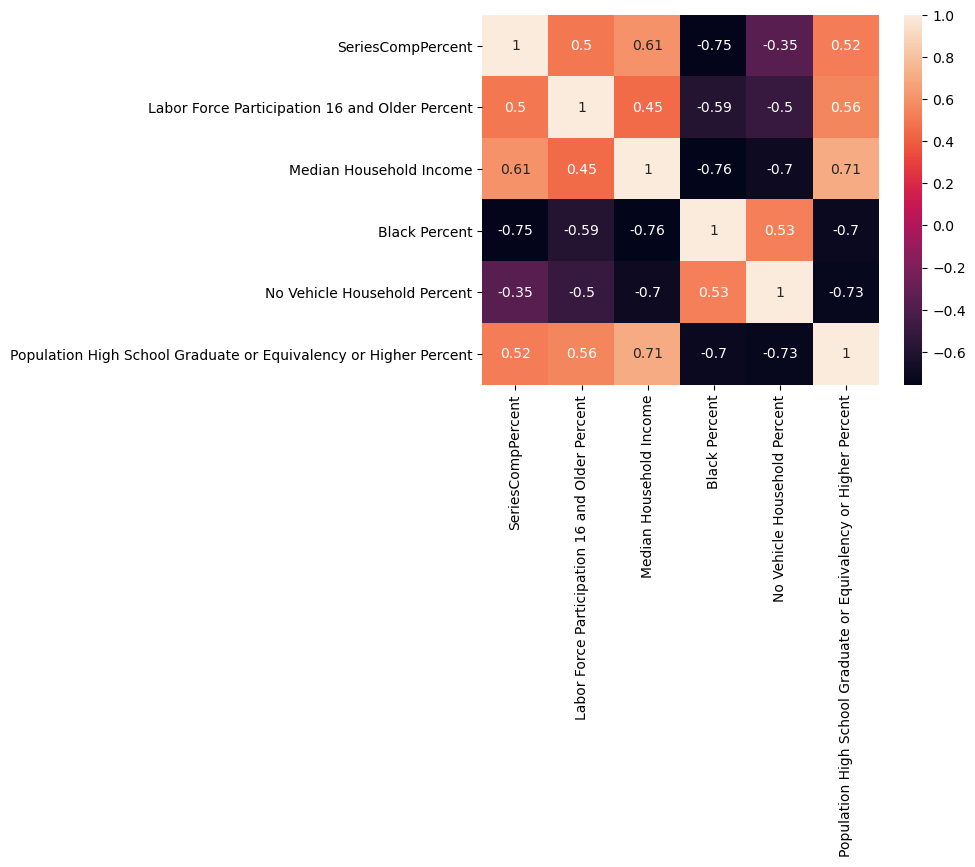

In [34]:
import seaborn as sn
import matplotlib.pyplot as plt

corrMatrix = df.iloc[:, 4:].corr()
sn.heatmap(corrMatrix, annot=True) # annot=True adds correleation coefficients to plot
plt.show()

### What does that mean for us?
<p>This means theat because of the high correlation between predictors, we want the model which has the least number of predictors (and thus the most <u>parsimonious</u> model) that still give us a fairly good <b>Adj. R-squared</b> value. The difference in <b>Adj. R-squared</b> values between <code>est_for</code> and <code>est_back</code> is fairly small at <code>0.574 - 0.556 = 0.018</code>. That is to say that in using the less parsimonious <code>est_back</code> model would only improve our model's ability to account for variability by 1.8% and is considerably more complex than the <code>est_for</code> model.</p> 

### What does this mean in English?
<p>Using multiple linear modelling techniques, we determined that out of all the predictors given, that the percentage of Black population was the best predictor for the percentage of the population who has not been vaccinated in Orleans Parish, Louisiana. While there are other predictors which also play a part, race encompases the other predictors and can be used to model vaccination rates for the parish.</p> 

### To work on next:
* <u>Notebook 1:</u> 
 * Now that we have a basic understanding of how linear modeling works using <code>StatsModels</code>, we should move on to using <code>SciKitLearn</code> which will allow for <b>cross validation</b> and more advanced techniques to be used to validate the model and perform <b>predictions</b>. 
     * I spent quite a while trying to get <b>predictions</b> working with <code>StatsModels</code>, but the documentation is not the best. I don't even think that <b>cross validation</b> is implemented in <code>StatsModels</code>.

* <u>Notebook 2:</u>
 * After that, log based modeling using a quick intro with <code>StatsModels</code> and then going in depth with <code>SciKitLearn</code>.
   * The R <code>logit()</code> function would be the best place to start with learn how it was ported over from R or if there is something similar in other Python packages. 
 * Since this notebook should be pretty short, it would be a good point to bring in <b>cross validation</b> and <b>predictions</b>. This notebook should go quicker in both writing and teaching as the basis for understanding the statistics for modeling was laid out in <u>Notebook 1</u>.

* <u>Notebook 3:</u>
 * Next would be using decision trees, something like <b>random forest</b> or the like. I have no experience with this yet, but glancing at some tutorials, I would think the same notebook style could be used for this type of modeling as well.

* <u>Notebook 4:</u>
 * Incorporating all of this modelling into making predictions and mapping using GIS tools, <code>Folium</code> or ESRI tools.
 * This could also be done piecemeal throughout, but it would be nice to have a culminating project. I'm going to guess this will be the easiest part of all these notebooks.  